In [22]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, accuracy_score, explained_variance_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [3]:
cols = ['iso_code', 'date', 'stringency_index', 'new_cases_per_million',
        'new_deaths_per_million', 'population_density']

df = pd.read_csv('owid-covid-data.csv', usecols=cols, parse_dates=['date']).dropna()

# convert date to day difference from start date
start_date = pd.to_datetime('31/12/2019')
df['date'] = df['date'].apply(lambda x: (x - start_date).days)


In [4]:
def encode_and_bind(main_df, feature_to_encode):
    dummies = pd.get_dummies(main_df[[feature_to_encode]])
    res = pd.concat([main_df, dummies], axis=1)
    return res


encoded = encode_and_bind(df, 'iso_code').drop(['iso_code'], axis=1)

outputs = ['new_cases_per_million', 'new_deaths_per_million']
Y = encoded[outputs]
X = encoded.drop(outputs, axis=1)

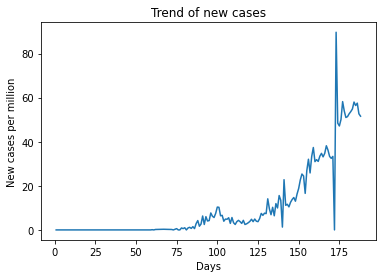

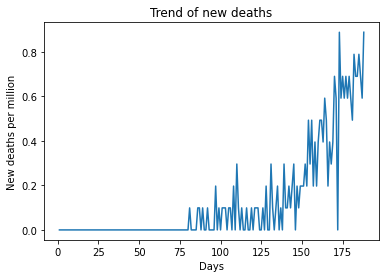

      date  new_cases_per_million  new_deaths_per_million  stringency_index  \
1978   175                 47.144                   0.690              96.3   
1979   176                 50.103                   0.592              96.3   
1980   177                 58.190                   0.690              96.3   
1981   178                 53.949                   0.592              96.3   
1982   179                 50.990                   0.690              96.3   
1983   180                 51.385                   0.592              96.3   
1984   181                 52.667                   0.493              96.3   
1985   182                 53.653                   0.789              96.3   
1986   183                 54.837                   0.690              96.3   
1987   184                 57.993                   0.690              96.3   
1988   185                 56.415                   0.789              96.3   
1989   186                 57.500                   

In [10]:
aze = encoded[encoded['iso_code_AZE'] == 1]


plt.plot(aze['date'], aze['new_cases_per_million'], label='Cases per million')
plt.xlabel('Days')
plt.ylabel('New cases per million')
plt.title('Trend of new cases')
plt.show()

plt.plot(aze['date'], aze['new_deaths_per_million'], label='Death per million')
plt.xlabel('Days')
plt.ylabel('New deaths per million')
plt.title('Trend of new deaths')
plt.show()

aze_last_weeks = aze[-14:]
print(aze_last_weeks)

In [5]:
def print_format(mod, sc1, sc2):
    model = str(mod).split('(')[0]  # get the name of model
    print(f'{model: <30} {sc1: .3f} {sc2: .3f}')
    
# create all models with default arguments
all_models = [RandomForestRegressor(), LinearRegression(), 
              Ridge(), Lasso(), ElasticNet()]


In [20]:
def train(model, X, Y):
    
    arr = []
    
    # 5-fold cross validation with train_test_split and shuffling data 
    for i in range(5):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, test_size=0.1)
            
        model.fit(X_train, Y_train)
        pred = model.predict(X_test)
        
        # store accuracy stores
        arr.append(explained_variance_score(Y_test.to_numpy(), pred, multioutput='raw_values'))
        #print(arr)
    
    # return average
    return np.mean(arr, axis=0)


print(f'{"model": <30} {"cases_accuracy": <10} {"death_accuracy": <10}')

# print their accuracy scores
for model in all_models:
    try:
        sc = train(model, X, Y)
        print_format(model, *sc)
    except:
        print(f'Not possible with {model}')
        

model                          cases_accuracy death_accuracy
RandomForestRegressor           0.683  0.388
LinearRegression                0.342  0.197
Ridge                           0.303  0.192
Lasso                           0.101  0.013
ElasticNet                      0.043  0.015


In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, shuffle=True)

X_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, Y_train)

pred = pol_reg.predict(poly_reg.fit_transform(X_test))
print_format(poly_reg, *explained_variance_score(Y_test.to_numpy(), pred, multioutput='raw_values'))


PolynomialFeatures              0.578  0.473


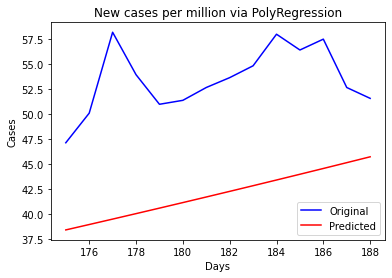

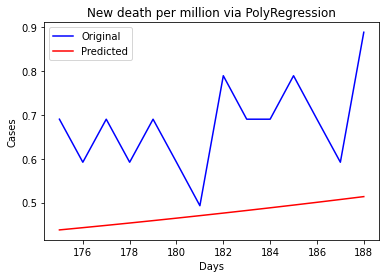

In [19]:
pred = pol_reg.predict(poly_reg.fit_transform(aze_last_weeks.drop(outputs, axis=1)))

plt.title(f"New cases per million via PolyRegression")
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(aze_last_weeks['date'], aze_last_weeks[outputs[0]], c='b', label='Original')
plt.plot(aze_last_weeks['date'], pred[:, 0], c='r', label='Predicted')
plt.legend()
plt.show()

plt.title(f"New death per million via PolyRegression")
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(aze_last_weeks['date'], aze_last_weeks[outputs[1]], c='b', label='Original')
plt.plot(aze_last_weeks['date'], pred[:, 1], c='r', label='Predicted')
plt.legend()
plt.show()

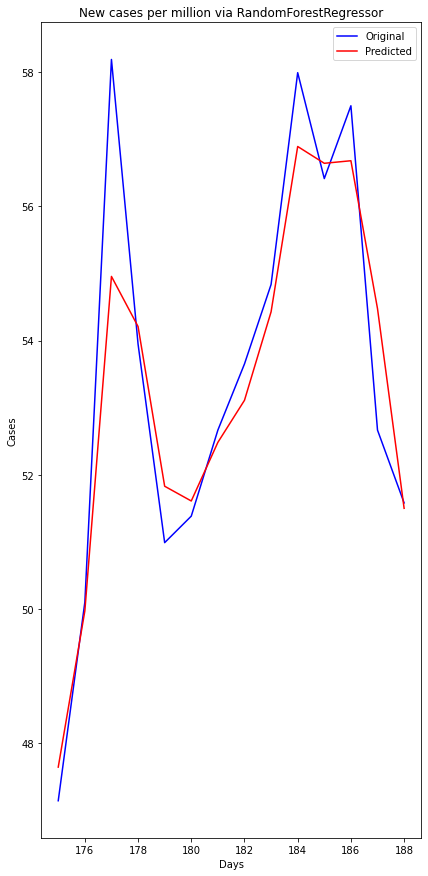

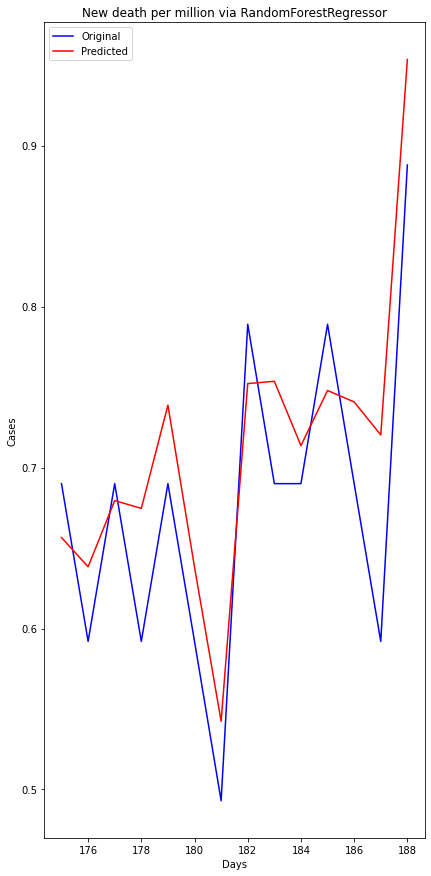

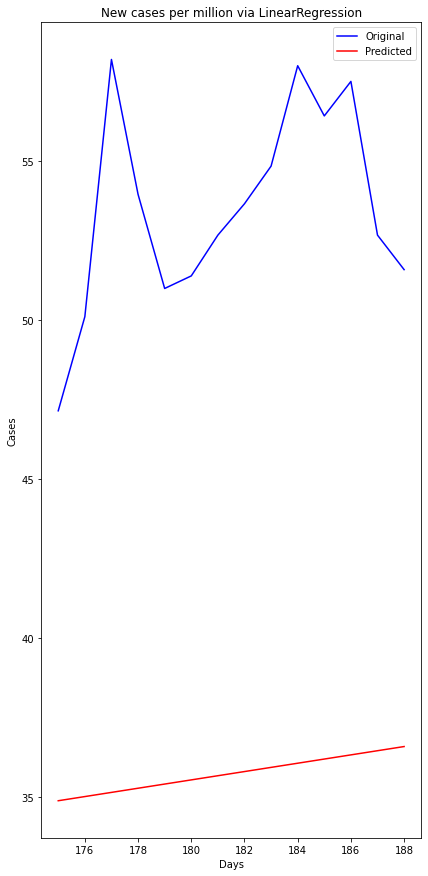

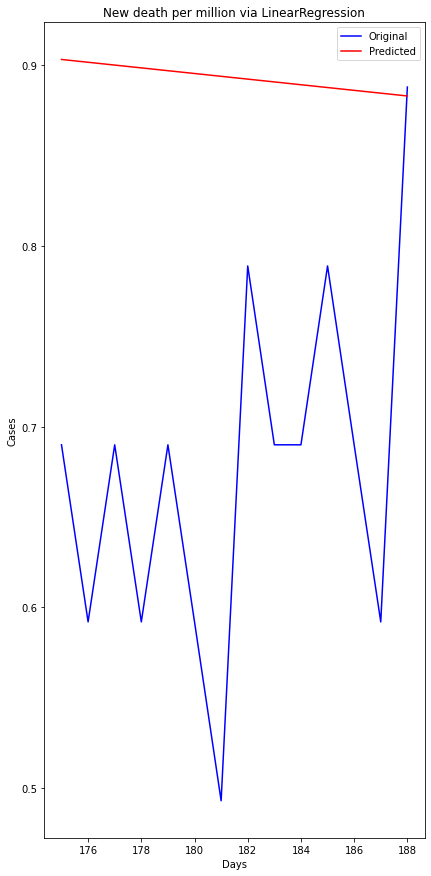

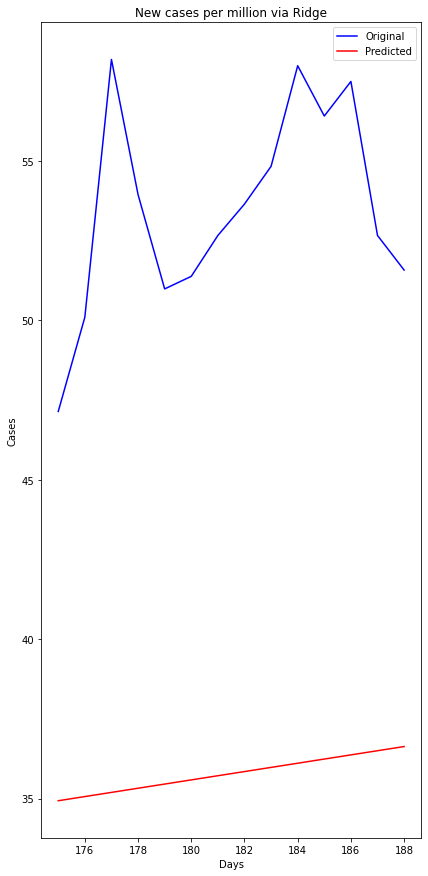

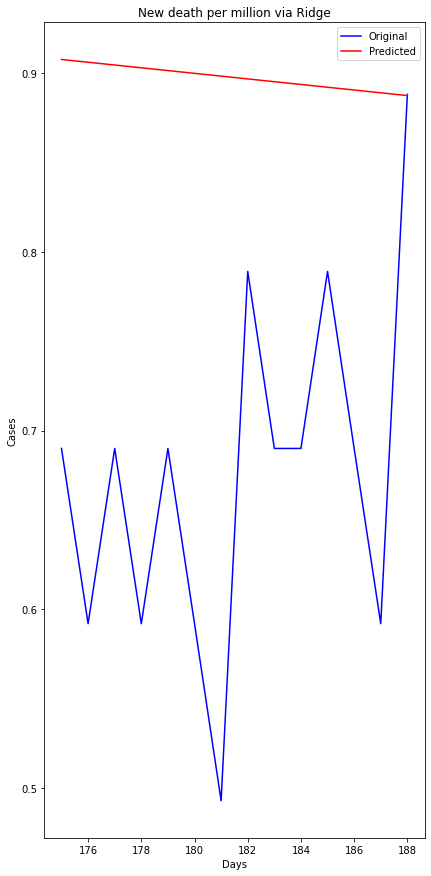

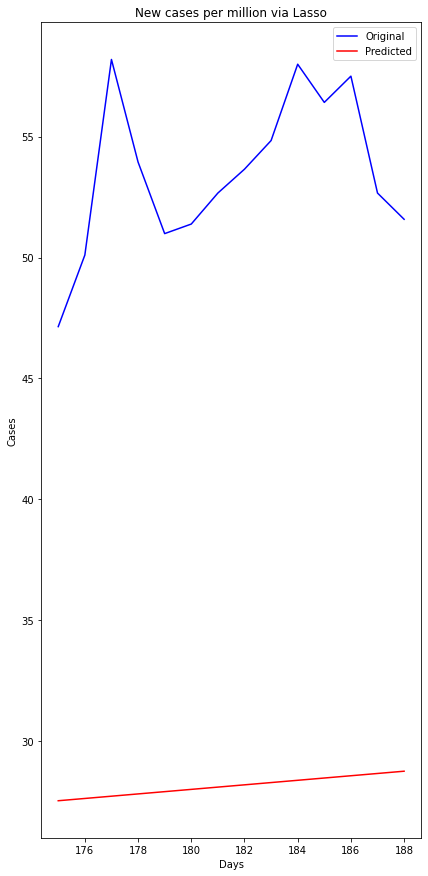

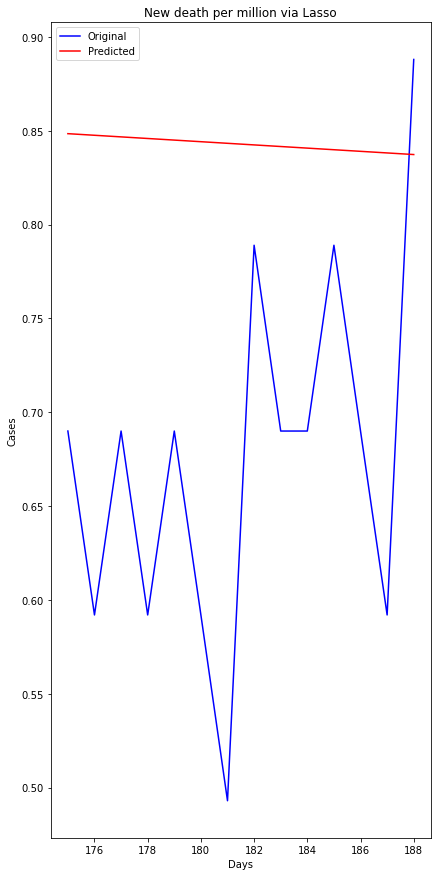

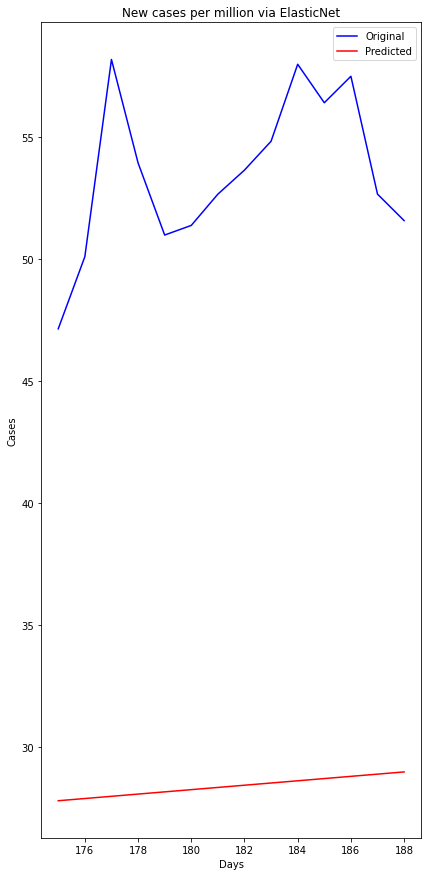

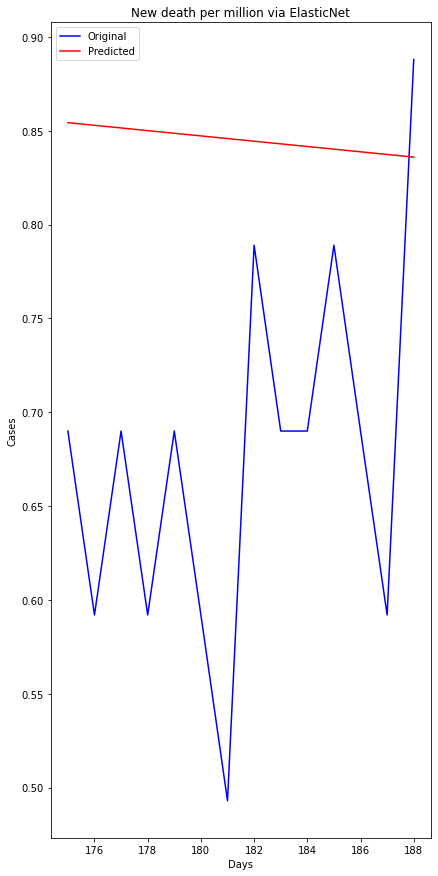

In [15]:
for model in all_models:
    model.fit(X, Y)
    
    pred = model.predict(aze_last_weeks.drop(outputs, axis=1))
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.title(f"New cases per million via {str(model).split('(')[0]}")
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.plot(aze_last_weeks['date'], aze_last_weeks[outputs[0]], c='b', label='Original')
    plt.plot(aze_last_weeks['date'], pred[:, 0], c='r', label='Predicted')
    plt.legend()

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 2)
    plt.title(f"New death per million via {str(model).split('(')[0]}")
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.plot(aze_last_weeks['date'], aze_last_weeks[outputs[1]], c='b', label='Original')
    plt.plot(aze_last_weeks['date'], pred[:, 1], c='r', label='Predicted')
    plt.legend()
    plt.show()
    

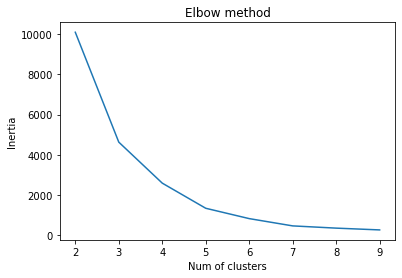

In [24]:
# KMeans

data = aze[outputs]
data

cluster = range(2, 10)
errors = []

for c in cluster:
    k = KMeans(c)
    
    k.fit(data)
    errors.append(k.inertia_)
    

plt.title('Elbow method')
plt.xlabel('Num of clusters')
plt.ylabel('Inertia')
plt.plot(cluster, errors)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 3 0 0 3 3 0 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 0 1 3 3 3 3 3 3 3 3 3 1 1 1 3 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


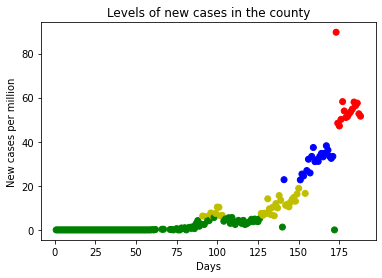

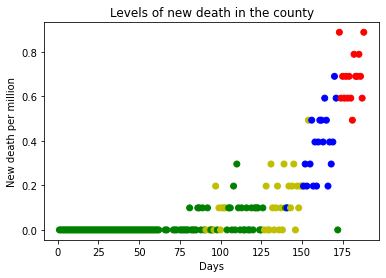

In [36]:
# Lets take 4 as optimal cluster number

k = KMeans(4)
k.fit(data)

print(k.labels_)
all_colors = ['g', 'b', 'r', 'y']

colors = [all_colors[x] for x in k.labels_]

plt.title('Levels of new cases in the county')
plt.xlabel('Days')
plt.ylabel('New cases per million')
plt.scatter(aze['date'], data[outputs[0]], c=colors)
plt.show()

plt.title('Levels of new death in the county')
plt.xlabel('Days')
plt.ylabel('New death per million')
plt.scatter(aze['date'], data[outputs[1]], c=colors)
plt.show()